In [37]:
import matplotlib.pyplot as plt
import json

from pts.dataset.repository import get_dataset
from pts.dataset.utils import to_pandas

from pts.model.deepar import DeepAREstimator
from pts.modules.distribution_output import ImplicitQuantileOutput
from pts import Trainer
from pts.evaluation import make_evaluation_predictions, Evaluator

In [38]:
import torch

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
dataset = get_dataset("m5", regenerate=False)

In [41]:
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Recommended prediction horizon: 28
Frequency of the time series: D


In [42]:
estimator = DeepAREstimator(
    distr_output=ImplicitQuantileOutput(output_domain="Positive"),
    cell_type='GRU',
    input_size=72,
    num_cells=64,
    num_layers=3,
    dropout_rate=0.2,
    use_feat_dynamic_real=True,
    use_feat_static_cat=True,
    cardinality=[int(cat_feat_info.cardinality) for cat_feat_info in dataset.metadata.feat_static_cat],
    embedding_dimension = [4, 4, 4, 4, 16],
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*2,
    freq=dataset.metadata.freq,
    scaling=True,
    trainer=Trainer(device=device,
                    epochs=20,
                    learning_rate=1e-3,
                    num_batches_per_epoch=120,
                    batch_size=256,
                    num_workers=8,
                    pin_memory=True,
                   )
)

In [43]:
predictor = estimator.train(dataset.train)

119it [01:01,  1.94it/s, avg_epoch_loss=0.435, epoch=0]
119it [00:56,  2.10it/s, avg_epoch_loss=0.366, epoch=1]
119it [00:59,  2.01it/s, avg_epoch_loss=0.344, epoch=2]
119it [00:57,  2.09it/s, avg_epoch_loss=0.339, epoch=3]
119it [00:57,  2.08it/s, avg_epoch_loss=0.323, epoch=4]
119it [00:56,  2.09it/s, avg_epoch_loss=0.339, epoch=5]
119it [00:58,  2.04it/s, avg_epoch_loss=0.327, epoch=6]
119it [00:56,  2.10it/s, avg_epoch_loss=0.327, epoch=7]
119it [00:57,  2.06it/s, avg_epoch_loss=0.328, epoch=8]
119it [00:58,  2.04it/s, avg_epoch_loss=0.331, epoch=9]
119it [00:57,  2.08it/s, avg_epoch_loss=0.322, epoch=10]
119it [00:59,  2.01it/s, avg_epoch_loss=0.319, epoch=11]
119it [00:58,  2.05it/s, avg_epoch_loss=0.321, epoch=12]
119it [00:58,  2.05it/s, avg_epoch_loss=0.319, epoch=13]
119it [00:58,  2.02it/s, avg_epoch_loss=0.321, epoch=14]
119it [00:55,  2.13it/s, avg_epoch_loss=0.326, epoch=15]
119it [00:57,  2.09it/s, avg_epoch_loss=0.326, epoch=16]
119it [00:59,  2.02it/s, avg_epoch_loss=0

In [44]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [45]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [46]:
evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))



Running evaluation: 100%|██████████| 30490/30490 [00:01<00:00, 15362.84it/s]


In [47]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 4.67881831019069,
    "abs_error": 829715.0852242557,
    "abs_target_sum": 1231764.0,
    "abs_target_mean": 1.4428196598416543,
    "seasonal_error": 1.12721783493784,
    "MASE": 0.8981459708461484,
    "MAPE": 0.32066903474970854,
    "sMAPE": 1.607201008190784,
    "OWA": NaN,
    "MSIS": 8.020464013332395,
    "QuantileLoss[0.1]": 228597.93391284882,
    "Coverage[0.1]": 0.5465105655249968,
    "QuantileLoss[0.2]": 427520.68589925097,
    "Coverage[0.2]": 0.5526788642646276,
    "QuantileLoss[0.3]": 596678.5831146002,
    "Coverage[0.3]": 0.5641638944853101,
    "QuantileLoss[0.4]": 733503.7435174085,
    "Coverage[0.4]": 0.5829768542379278,
    "QuantileLoss[0.5]": 829715.0852156124,
    "Coverage[0.5]": 0.6140994705524139,
    "QuantileLoss[0.6]": 881578.0619610748,
    "Coverage[0.6]": 0.6517195333364716,
    "QuantileLoss[0.7]": 872760.4227906723,
    "Coverage[0.7]": 0.7082111230848716,
    "QuantileLoss[0.8]": 783768.9510111441,
    "Coverage[0.8]": 0.784648362

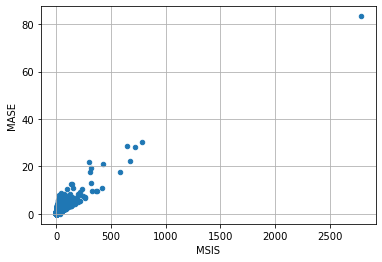

In [48]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()